#Demarrage

## Import librairie


In [1]:
import sys
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter
import string
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import pydot

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')

!python -m spacy download fr_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 33.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##Montage du drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

my_local_drive='/content/gdrive/My Drive/TER'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Mounted at /content/gdrive/
/content/gdrive/My Drive/TER


'/content/gdrive/My Drive/TER'

##Importation du dataset

In [3]:
#lien du tutoriel video pour l'utilisation du model CNN
#https://www.youtube.com/watch?v=MsL79ZIqWpg

df = pd.read_csv('conversation_data.csv')
df_test = pd.read_csv('test.csv')

display(df.head())

display(df_test.head())

,Jeu,Player,Role,Response,evaluation
0,1,Claire,Villageois,"Hold on a second, are we forgetting about Luca...",True
1,1,Thomas,Loups-Garous,"You will regret it, I'm not the werewolf. I'm ...",False
2,1,Emma,Villageois,i suspect that Claire is the werewolf.\n\nThe ...,False
3,1,Lucas,Loups-Garous,I am innocent... I am a simple villager. I am ...,False
4,1,Laura,Voyante,I think Thomas is the werewolf. I think he's t...,True


,round,player,role,response,evaluation
0,1,Claire,Villageois,I agree with Marie. Emma's sudden interest in ...,True
1,1,Thomas,Docteur,"Well, I have my suspicions. Emma was awfully q...",True
2,1,Emma,Loups-Garous,Marie is the voyante i think !!\r\n\r\nI'm so ...,True
3,1,Lucas,Loups-Garous,Marie is the voyante i think ive ever met ive ...,True
4,1,Laura,Villageois,"Hold on a second, are we forgetting about Luca...",True


#Pretraitement



##Nettoyage de la reponse Option 1

In [ ]:
nlp = spacy.load('fr_core_news_sm')

def process_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nlp(text)
    tokens = [token.lemma_ for token in tokens if not token.is_stop]
    return ' '.join(tokens)

df['reponse'] = df['reponse'].apply(process_text)


display(df.head())

,round,role,reponse,evaluation
0,1,villageois,croire claire thomas avoir frapper loupsgarou,Vrai
1,1,villageois,attend laurer sauter conclusion devoir examine...,Vrai
2,1,villageois,emma astu vision nuit peuxtu aider confirmer...,Vrai
3,1,villageois,jai scruter lâm thomas nuit bel bien loupgarou,Vrai
4,1,villageois,devoir éliminer clair thomas loupgarou mentir ...,Vrai


##Nettoyage de la reponse Option 2

In [11]:

stop_words = set(stopwords.words('english'))

def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>1))])

    return text2.lower()

    stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered_tokens)

df['Response'] = df['Response'].apply(remove_stop_words)


nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

df['Response'] = df['Response'].apply(clean_text)
df['Response'] = df['Response'].apply(lemmatize)
df['Response'] = df['Response'].apply(remove_stop_words)


df_test['response'] = df_test['response'].apply(clean_text)
display(df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Jeu,Player,Role,Response,evaluation
0,1,Claire,Villageois,hold second forget lucas play simple villager ...,True
1,1,Thomas,Loups-Garous,regret werewolf man werewolf man werewolf man ...,False
2,1,Emma,Villageois,suspect claire werewolf next day claire see ho...,False
3,1,Lucas,Loups-Garous,innocent simple villager villager villager vil...,False
4,1,Laura,Voyante,think thomas werewolf think one go kill think ...,True


##Nb max de mot dans les reponses

In [13]:
df.dropna(axis = 0, how ='any',inplace=True)
df['Nb_mot'] = df['Response'].apply(lambda x:len(str(x).split()))

df_test.dropna(axis = 0, how ='any',inplace=True)
df_test['Nb_mot'] = df_test['response'].apply(lambda x:len(str(x).split()))

print(df['Nb_mot'].max())

44


##Tokenisation et Vectorization

In [14]:
num_words = 20000

#lorsque on vectorise on map un mot avec un index de dictionnaire

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(df['Response'].tolist())


print(str(tokenizer.texts_to_sequences(['je peux pas alors'])))
print(str(tokenizer.texts_to_sequences(['i am not there'])))

[[1, 1, 1, 1]]
[[1, 1, 1, 1]]


#Suite

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(df['Response'].tolist(),\
                                                      df['evaluation'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = df['evaluation'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid))+'\n')



x_train = tokenizer.texts_to_sequences(X_train)
x_valid = tokenizer.texts_to_sequences(X_valid)
x_test  = tokenizer.texts_to_sequences(df_test['response'].tolist())

#on estime le max len des reponses a 24 mots
maxNbMot = 83

#pour chaque matrice de reponse on remplis de 0 pour qu'elles aient
#toutes la même taille
x_train = pad_sequences(x_train, padding='post', maxlen=maxNbMot)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxNbMot)
x_test = pad_sequences(x_test, padding='post', maxlen=maxNbMot)

print('x_train[0]\n')
print(x_train[0])

#en gros on transforme les noms de categorie en nombre
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(df_test['evaluation'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

display(train_ds)

Train data len:800
Class distributionCounter({True: 572, False: 228})
Valid data len:200
Class distributionCounter({True: 143, False: 57})

x_train[0]

[ 53  56  71  17  48   5   4  57  12  39  24  15  21  74 176  24 740 575
  21  74 176  24  10 326 291  15  21  74   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


<_TensorSliceDataset element_spec=(TensorSpec(shape=(83,), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [16]:
print('y_train\n')
print(y_train[:10])
print('\n')
train_labels = le.fit_transform(y_train)
print('text to number')
print(train_labels[:10])
print('\n')
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

y_train

[True, False, True, True, True, False, False, True, True, True]


text to number
[1 0 1 1 1 0 0 1 1 1]


Number to category
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#Creation model CNN

In [17]:
max_features =20000
embedding_dim =64
sequence_length = 83

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))




model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 83, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 81, 128)           24704     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1305026 (4.98 MB)
Trainable params: 1305026 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

#Entrainement du model

In [18]:
epochs = 100#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 7s 396ms/step - loss: 1.2298 - categorical_accuracy: 0.4238 - val_loss: 1.1023 - val_categorical_accuracy: 0.7200
Epoch 2/100
7/7 [==============================] - 0s 52ms/step - loss: 1.0271 - categorical_accuracy: 0.7275 - val_loss: 0.9190 - val_categorical_accuracy: 0.7150
Epoch 3/100
7/7 [==============================] - 0s 53ms/step - loss: 0.8540 - categorical_accuracy: 0.7163 - val_loss: 0.7693 - val_categorical_accuracy: 0.7150
Epoch 4/100
7/7 [==============================] - 0s 69ms/step - loss: 0.7146 - categorical_accuracy: 0.7175 - val_loss: 0.6527 - val_categorical_accuracy: 0.7150
Epoch 5/100
7/7 [==============================] - 0s 63ms/step - loss: 0.6091 - categorical_accuracy: 0.7287 - val_loss: 0.5536 - val_categorical_accuracy: 0.7300
Epoch 6/100
7/7 [==============================] - 0s 67ms/step - loss: 0.5113 - categorical_accuracy: 0.8050 - val_loss: 0.4610 - val_categorical_accuracy: 0.8750
Epoch 7/100
7/7 [==========

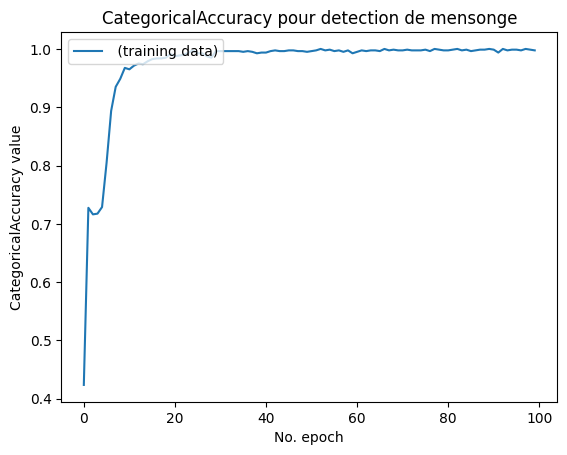

In [22]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.title('CategoricalAccuracy pour detection de mensonge')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()



In [23]:
predictions = model.predict(x_test)
predict_results = predictions.argmax(axis=1)
print(predictions)

1/1 [==============================] - 0s 324ms/step
[[0.1241642  0.90774167]
 [0.12007573 0.9125638 ]
 [0.10975729 0.91801333]
 [0.08704592 0.9382977 ]
 [0.04663657 0.97139573]
 [0.42474818 0.62880605]
 [0.05287415 0.96667504]
 [0.09174969 0.9342209 ]
 [0.12007573 0.9125638 ]
 [0.91074115 0.08693281]
 [0.05918394 0.9620026 ]
 [0.9219211  0.07325137]
 [0.19633527 0.8381098 ]
 [0.9081095  0.09493129]
 [0.0456077  0.97084767]
 [0.03541283 0.9787565 ]
 [0.09356422 0.9340956 ]
 [0.06669933 0.9564045 ]
 [0.92139405 0.07358311]
 [0.04968667 0.9680861 ]
 [0.41576585 0.6322895 ]
 [0.08554523 0.93943506]
 [0.03857454 0.97633713]
 [0.57413787 0.45228043]
 [0.13738096 0.89464784]
 [0.92139405 0.07358311]
 [0.05931004 0.96195626]
 [0.19739823 0.83685505]
 [0.92138594 0.0735883 ]
 [0.11584235 0.91577005]]


In [24]:
df_test['pred_evaluation']= predict_results
df_test['pred_evaluation'] = np.where((df_test.pred_evaluation == 0),'False',df_test.pred_evaluation)
df_test['pred_evaluation'] = np.where((df_test.pred_evaluation == '1'),'True',df_test.pred_evaluation)

#display(df_test['pred_evaluation'])
#display(df_test['evaluation'])

#Conversion string en bool
df_test['pred_evaluation'] = df_test['pred_evaluation'].apply(lambda x: True if x == 'True' else False)

labels = ['True', 'False']

print(classification_report(df_test['evaluation'],df_test['pred_evaluation'],labels=labels))


              precision    recall  f1-score   support

        True       0.91      1.00      0.95        21
       False       1.00      0.78      0.88         9

   micro avg       0.93      0.93      0.93        30
   macro avg       0.96      0.89      0.91        30
weighted avg       0.94      0.93      0.93        30

